In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME =  "SOCAIT/Fitness"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SOCAIT/Fitness
'Copy of MistralFinetunePhiloso.ipynb'	 mistral-recipe-finetune	 TRL.ipynb
 fitness_data				 nutrition_data_analysis.ipynb	 wandb
 fitness_data_analysis.ipynb		 SFT.ipynb


In [2]:
!pip install -U transformers datasets accelerate peft trl bitsandbytes wandb

In [3]:
import pandas as pd

recipes_df = pd.read_csv("fitness_data/nutrition/recipes_rewards.csv")


In [4]:
recipes_df.head()

,Unnamed: 0,user_id,recipe_id,date,rating,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,sentiment,probability
0,0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9,LABEL_1,0.975574
1,1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9,LABEL_1,0.984492
2,3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13,LABEL_1,0.804223
3,4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13,LABEL_1,0.773250
4,5,52282,120345,2005-05-21,4,very very sweet. after i waited the 2 days i b...,sugared raspberries,10,37449,2005-05-02,"['15-minutes-or-less', 'time-to-make', 'course...","[838.0, 1.0, 820.0, 0.0, 2.0, 0.0, 71.0]",6,"['carefully pick over the berries , removing l...",here's an old method for preserving fruit with...,"['raspberries', 'granulated sugar']",2,LABEL_1,0.854262


In [5]:
recipes_df['sentiment_weight'] =  recipes_df['sentiment'].map(lambda q: 5 if q=='LABEL_1' else  -5)
recipes_df['sentiment_weight'].head()

,sentiment_weight
0,5
1,5
2,5
3,5
4,5


In [6]:
recipes_df['reward'] = recipes_df['probability'] * recipes_df['sentiment_weight']

In [7]:
# Convert the 'name' column to title case
recipes_df['name'] = recipes_df['name'].apply(lambda x: x.title())

In [8]:
recipes_df.head()

,Unnamed: 0,user_id,recipe_id,date,rating,review,name,minutes,contributor_id,submitted,...,nutrition,n_steps,steps,description,ingredients,n_ingredients,sentiment,probability,sentiment_weight,reward
0,0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,White Bean Green Chile Pepper Soup,495,1533,2002-09-21,...,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9,LABEL_1,0.975574,5,4.877869
1,1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",White Bean Green Chile Pepper Soup,495,1533,2002-09-21,...,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9,LABEL_1,0.984492,5,4.922462
2,3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,Baked Potato Toppings,10,64342,2004-02-25,...,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13,LABEL_1,0.804223,5,4.021114
3,4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",Baked Potato Toppings,10,64342,2004-02-25,...,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13,LABEL_1,0.773250,5,3.866250
4,5,52282,120345,2005-05-21,4,very very sweet. after i waited the 2 days i b...,Sugared Raspberries,10,37449,2005-05-02,...,"[838.0, 1.0, 820.0, 0.0, 2.0, 0.0, 71.0]",6,"['carefully pick over the berries , removing l...",here's an old method for preserving fruit with...,"['raspberries', 'granulated sugar']",2,LABEL_1,0.854262,5,4.271308


In [9]:
recipes_df.iloc[0]['tags']

"['weeknight', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'soups-stews', 'beans', 'vegetables', 'easy', 'crock-pot-slow-cooker', 'dietary', 'equipment']"

In [10]:
import  seaborn as sns
import matplotlib.pyplot as plt

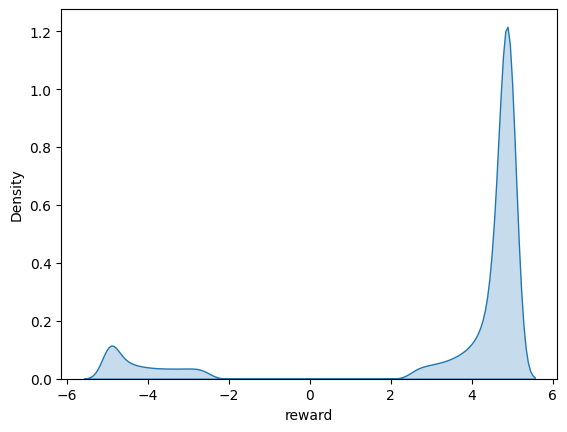

In [11]:
# Plot
sns.kdeplot(data=recipes_df['reward'], fill=True)
plt.show()

In [12]:
# Define aggregation functions
def aggregate_data(df):
    # Define how to aggregate numeric columns
    aggregated_data = {
        'reward': df['reward'].mean(),  # Average reward
        'name': df['name'].iloc[0],  # Assuming name is consistent per recipe
        'description': df['description'].iloc[0],
        'ingredients': df['ingredients'].iloc[0],  # Choose the first or refine if needed
        'steps': df['steps'].iloc[0],  # Choose the first or refine
        'nutrition': df['nutrition'].iloc[0],  # Choose the first or refine
        'minutes': df['minutes'].iloc[0]

    }

    return pd.Series(aggregated_data)

# Group the DataFrame by recipe_id and aggregate using the function
grouped_df = recipes_df.groupby('recipe_id').apply(aggregate_data).reset_index()

In [13]:
grouped_df.head()

,recipe_id,reward,name,description,ingredients,steps,nutrition,minutes
0,38,4.694808,Low Fat Berry Blue Frozen Dessert,"this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...","['toss 2 cups berries with sugar', 'let stand ...","[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",1485
1,39,-4.702760,Biryani,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",['soak saffron in warm milk for 5 minutes and ...,"[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]",265
2,40,3.510922,Best Lemonade,this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...","['into a 1 quart jar with tight fitting lid , ...","[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",35
3,41,4.548118,Carina S Tofu Vegetable Kebabs,this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...","['drain the tofu , carefully squeezing out exc...","[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",1460
4,43,-4.996861,Best Blackbottom Pie,"sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...","['graham cracker crust: in small bowl , combin...","[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]",140


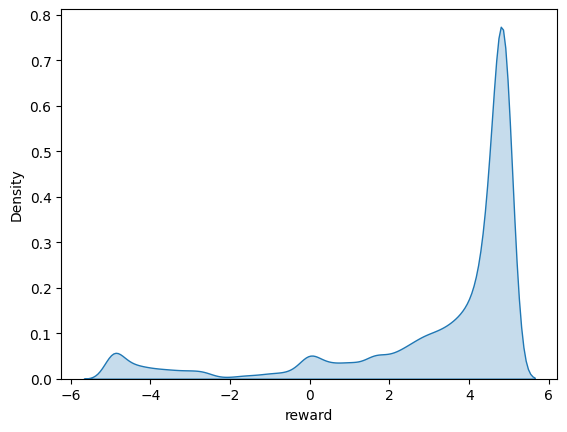

In [14]:
# Plot
sns.kdeplot(data=grouped_df['reward'], fill=True)
plt.show()

In [15]:
system_role = " You are a helpful assistant in the domain of Fitness and Nutrition."

In [16]:
import ast

nutrients = [
        'calories',
        'fat',
        'sugar',
        'sodium',
        'protein',
        'saturated_fat',
        'carbohydrates'
 ]
def convert_pdv_to_grams(nutrient, pdv):
    daily_values = {
        'fat': 78,  # grams
        'sugar': 50,  # grams
        'sodium': 2300,  # milligrams
        'protein': 50,  # grams
        'saturated_fat': 20,  # grams
        'carbohydrates': 275,  # grams
    }

    if nutrient=='calories':
        return pdv  # number of calories

    # Convert the PDV to an actual amount
    if nutrient in daily_values:
        amount = daily_values[nutrient] * pdv / 100
        # Convert sodium to grams if necessary
        # if nutrient == 'sodium':
        #     amount /= 1000
        return amount
    else:
        raise ValueError(f"Nutrient '{nutrient}' is not recognized or supported.")

def step_format(i, step):
   return " " + str(i+1) + ". " + step

def create_dialogue(row):
    # User prompt
    user_prompt = "Can you suggest a high-rated recipe for dinner?"

    # Assistant's initial response
    assistant_response = f"Absolutely! One popular choice is {row['name']}. It's {row['description']} Would you like to know the ingredients, steps, and nutritional information?"

    # User follow-up
    user_followup = "Yes, please tell me the ingredients, how to make it, and the nutritional details."

    # Assistant's detailed response
    ingredients_list =  ast.literal_eval(row['ingredients'])
    ingredients = ', '.join(ingredients_list)  # Assuming ingredients is a list

     # Convert the 'steps' string into a list
    steps_list = ast.literal_eval(row['steps'])
    steps_list = [step_format(i, steps_list[i]) for i in range(len(steps_list))]
    steps = '\n'.join(steps_list)  # Combine steps into a single string

    # Formatting nutrition data
    # Example nutrition format in the DataFrame: [calories, fat, sugar, sodium, protein, sat_fat, fiber]
    nutrition_list = ast.literal_eval(row['nutrition'])
    nutrition = [convert_pdv_to_grams(nutrients[i], nutrition_list[i]) for i in range(len(nutrition_list))]
    nutrition_details = f"Calories: {nutrition[0]}, Fat: {nutrition[1]}g, Sugar: {nutrition[2]}g, Sodium: {nutrition[3]}mg, Protein: {nutrition[4]}g, Saturated Fat: {nutrition[5]}g, Carbs: {nutrition[6]}g"

    assistant_detailed_response = f"The ingredients you’ll need are: {ingredients}.\n\n Here are the steps:\n{steps}.\n\n Nutritional details:\n {nutrition_details}. \n\n Duration Time: about {row['minutes']} minutes"

    messages = [
    {"role": "system", "content": system_role},
    {"role": "user", "content": user_prompt},
    {"role": "assistant", "content": assistant_response},
    {"role": "user", "content": user_followup},
    {"role": "assistant", "content": assistant_detailed_response},


    ]

    return  messages, assistant_detailed_response,

# Example usage:
# Assuming 'df' is your DataFrame and you're using the first row for this example
dialogue_example = create_dialogue(recipes_df.iloc[0])
for line in dialogue_example:
    print(line)


[{'role': 'system', 'content': ' You are a helpful assistant in the domain of Fitness and Nutrition.'}, {'role': 'user', 'content': 'Can you suggest a high-rated recipe for dinner?'}, {'role': 'assistant', 'content': "Absolutely! One popular choice is White Bean   Green Chile Pepper Soup. It's easy soup for the crockpot. Would you like to know the ingredients, steps, and nutritional information?"}, {'role': 'user', 'content': 'Yes, please tell me the ingredients, how to make it, and the nutritional details.'}, {'role': 'assistant', 'content': 'The ingredients you’ll need are: great northern beans, yellow onion, diced green chilies, ground cumin, garlic powder, fat-free chicken broth, fresh cilantro leaves, extra virgin olive oil, sour cream.\n\n Here are the steps:\n 1. combine beans , onion , chilies , 1 / 2 teaspoon cumin , garlic powder and broth in crock pot\n 2. cook on low 8 hours or on high 4 hours\n 3. stir in cilantro , olive oil and remaining 1 / 2 teaspoon cumin\n 4. garnish

In [17]:
from datasets import Dataset
import json

In [18]:
grouped_df.head()

,recipe_id,reward,name,description,ingredients,steps,nutrition,minutes
0,38,4.694808,Low Fat Berry Blue Frozen Dessert,"this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...","['toss 2 cups berries with sugar', 'let stand ...","[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",1485
1,39,-4.702760,Biryani,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",['soak saffron in warm milk for 5 minutes and ...,"[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]",265
2,40,3.510922,Best Lemonade,this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...","['into a 1 quart jar with tight fitting lid , ...","[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",35
3,41,4.548118,Carina S Tofu Vegetable Kebabs,this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...","['drain the tofu , carefully squeezing out exc...","[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",1460
4,43,-4.996861,Best Blackbottom Pie,"sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...","['graham cracker crust: in small bowl , combin...","[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]",140


In [19]:
threshold = 2

In [20]:
# Apply the dialogue creation function to each row in the DataFrame
# Ensure your DataFrame is filtered to include only high-reward recipes
dialogues = grouped_df[grouped_df['reward'] > threshold].apply(create_dialogue, axis=1)


In [21]:
grouped_df[['messages', 'assistant_answer']] = grouped_df.apply(lambda row: create_dialogue(row), axis=1, result_type='expand')

In [22]:
grouped_df.head()

,recipe_id,reward,name,description,ingredients,steps,nutrition,minutes,messages,assistant_answer
0,38,4.694808,Low Fat Berry Blue Frozen Dessert,"this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...","['toss 2 cups berries with sugar', 'let stand ...","[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",1485,"[{'role': 'system', 'content': ' You are a hel...","The ingredients you’ll need are: blueberries, ..."
1,39,-4.702760,Biryani,"delhi, india","['saffron', 'milk', 'hot green chili peppers',...",['soak saffron in warm milk for 5 minutes and ...,"[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]",265,"[{'role': 'system', 'content': ' You are a hel...","The ingredients you’ll need are: saffron, milk..."
2,40,3.510922,Best Lemonade,this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...","['into a 1 quart jar with tight fitting lid , ...","[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",35,"[{'role': 'system', 'content': ' You are a hel...","The ingredients you’ll need are: sugar, lemons..."
3,41,4.548118,Carina S Tofu Vegetable Kebabs,this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...","['drain the tofu , carefully squeezing out exc...","[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",1460,"[{'role': 'system', 'content': ' You are a hel...",The ingredients you’ll need are: extra firm to...
4,43,-4.996861,Best Blackbottom Pie,"sweet, chocolatey, yummy","['graham cracker crumbs', 'sugar', 'butter', '...","['graham cracker crust: in small bowl , combin...","[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]",140,"[{'role': 'system', 'content': ' You are a hel...",The ingredients you’ll need are: graham cracke...


In [23]:
final_df = grouped_df[grouped_df['reward'] > 2][['messages', 'assistant_answer']]

In [24]:
final_df.shape

(180838, 2)

In [25]:
def extract_last_answer(row):
    for message in reversed(row):
        if message["role"] == "assistant":
            return message["content"]

def preprocess_conversations(input_file, output_file):
    with open(input_file, "r", encoding="utf-8") as f:
        conversations = [json.loads(line.strip()) for line in f]

    processed_data = []
    for conversation in conversations:
        last_answer = extract_last_answer(conversation)
        if last_answer:
            # Extracting relevant information from the last answer
            recipe_info = last_answer.split('\n')
            ingredients = recipe_info[0]
            steps = recipe_info[1]
            nutritional_details = recipe_info[2]

            # Storing the information in the instruction format
            processed_data.append({"prompt": "", "completion": last_answer})

    # Write the processed data to the output file
    with open(output_file, "w", encoding="utf-8") as f:
        for item in processed_data:
            f.write(json.dumps(item) + "\n")

In [26]:
final_df['query'] = final_df['messages']

In [27]:
final_df.head()

,messages,assistant_answer,query
0,"[{'role': 'system', 'content': ' You are a hel...","The ingredients you’ll need are: blueberries, ...","[{'role': 'system', 'content': ' You are a hel..."
2,"[{'role': 'system', 'content': ' You are a hel...","The ingredients you’ll need are: sugar, lemons...","[{'role': 'system', 'content': ' You are a hel..."
3,"[{'role': 'system', 'content': ' You are a hel...",The ingredients you’ll need are: extra firm to...,"[{'role': 'system', 'content': ' You are a hel..."
6,"[{'role': 'system', 'content': ' You are a hel...","The ingredients you’ll need are: rice vinegar,...","[{'role': 'system', 'content': ' You are a hel..."
7,"[{'role': 'system', 'content': ' You are a hel...",The ingredients you’ll need are: fresh mushroo...,"[{'role': 'system', 'content': ' You are a hel..."


In [28]:
final_df.iloc[0]['query']

[{'role': 'system',
  'content': ' You are a helpful assistant in the domain of Fitness and Nutrition.'},
 {'role': 'user',
  'content': 'Can you suggest a high-rated recipe for dinner?'},
 {'role': 'assistant',
  'content': "Absolutely! One popular choice is Low Fat Berry Blue Frozen Dessert. It's this is yummy and low-fat, it always turns out perfect. Would you like to know the ingredients, steps, and nutritional information?"},
 {'role': 'user',
  'content': 'Yes, please tell me the ingredients, how to make it, and the nutritional details.'},
 {'role': 'assistant',
  'content': 'The ingredients you’ll need are: blueberries, granulated sugar, vanilla yogurt, lemon juice.\n\n Here are the steps:\n 1. toss 2 cups berries with sugar\n 2. let stand for 45 minutes , stirring occasionally\n 3. transfer berry-sugar mixture to food processor\n 4. add yogurt and process until smooth\n 5. strain through fine sieve\n 6. pour into baking pan\n 7. freeze uncovered until edges are solid but centre

In [29]:
messages = [
    {"role": "system", "content": "You are Hermes 2."},
    {"role": "user", "content": "Hello, who are you?"}
]

def chatml_format(messages):
  gen_input = tokenizer.apply_chat_template(messages, add_generation_prompt=True,)
  return gen_input


In [30]:
model_name = '../SOCAIT-2.5-Mistral-7B'

In [31]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers

# from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer

# model = AutoModelForCausalLM.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenizer.pad_token = tokenizer.eos_token

In [32]:
model = None

In [33]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# base_model_id = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [35]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True)

In [36]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [37]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041216 || all params: 3837128768 || trainable%: 2.2162721436196535


In [38]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [39]:
model = accelerator.prepare_model(model)

In [40]:
# Decode token IDs to text
text = tokenizer.decode(chatml_format(messages))
print(text)

<|im_start|> system
You are Hermes 2.<|im_end|> 
<|im_start|> user
Hello, who are you?<|im_end|> 
<|im_start|> assistant



In [41]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into training and evaluation sets
train_df, eval_df = train_test_split(final_df, test_size=0.005, random_state=42)

# Display the number of rows in each set
print(f"Training set size: {len(train_df)}")
print(f"Evaluation set size: {len(eval_df)}")

Training set size: 179933
Evaluation set size: 905


In [42]:
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
eval_dataset

Dataset({
    features: ['messages', 'assistant_answer', 'query', '__index_level_0__'],
    num_rows: 905
})

In [43]:
#dataset['formatted_chat']

In [44]:
max_length = 2048
def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [45]:
train_dataset = train_dataset.map(lambda x: {"formatted_chat": tokenizer.apply_chat_template(x["messages"], tokenize=False, add_generation_prompt=True)})
eval_dataset = eval_dataset.map(lambda x: {"formatted_chat": tokenizer.apply_chat_template(x["messages"], tokenize=False, add_generation_prompt=True)})

Map:   0%|          | 0/179933 [00:00<?, ? examples/s]

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

In [46]:
train_dataset = train_dataset.map(lambda x: generate_and_tokenize_prompt(x["formatted_chat"]))
eval_dataset = eval_dataset.map(lambda x: generate_and_tokenize_prompt(x["formatted_chat"]))

Map:   0%|          | 0/179933 [00:00<?, ? examples/s]

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

In [47]:
from datetime import datetime

project = "recipe-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=0,
        per_device_train_batch_size=10,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        num_train_epochs=1,
        #max_steps=500,
        learning_rate=2e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=250,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=250,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Currently logged in as: giannispast9. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
250,2.012100,1.929399
500,1.278600,1.282547
750,1.177600,1.168341
1000,1.127600,1.130889
1250,1.102600,1.109882


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setti

Step,Training Loss,Validation Loss
250,2.012100,1.929399
500,1.278600,1.282547
750,1.177600,1.168341
1000,1.127600,1.130889
1250,1.102600,1.109882
1500,1.104100,1.095267
1750,1.091300,1.084479


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setti

KeyboardInterrupt: 

In [ ]:
from datasets import load_dataset
from trl import SFTTrainer


In [ ]:
# dataset_code = load_dataset("lucasmccabe-lmi/CodeAlpaca-20k", split="train")
# dataset_code

In [ ]:

response_template = " ### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

trainer = SFTTrainer(
    model,
    train_dataset=dataset,
    formatting_func=chatml_format,
    data_collator=collator,
)


trainer.train()